# 1 Master Data
## Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

## 1.1 Converting txt to csv

In [2]:
#define variables
inpath = "../00_data/masterdata/raw data/"
intype = ".txt"
incode = "utf-8"
outpath = "../00_data/masterdata/csv/"
outtype = ".csv"
outcode = "utf-8"

#define dataselection
years = ["2016"]

for y in years:
    with open (outpath + "masterdata_" + y + outtype,"w",encoding=outcode) as outfile:
        infile = inpath + "masterdata_" + y + intype 
        with open (infile, encoding=incode) as infile:
            for line in infile:
                outfile.write(line)

## 1.2 Editing csv-files via pandas

http://pandas.pydata.org/
- Eliminating old header
- Insert new header
- Save new csv-file

In [3]:
header = ["CardID","CustID","CustID old","Title","Country","Address", 
          "PostalCode","City","Mail","BirthDate","noAd","ValidityDate"]
columns = [0,1,2,3,4,5,6,7,8,9,10,11,12]

In [4]:
def new_csv_after_pd (var, year):
    df = pd.read_csv(var, delimiter=";", encoding="utf-8", names=header, usecols=columns, 
                     skiprows=8, skipfooter=1, na_filter=False, skip_blank_lines=False, 
                     error_bad_lines=False, warn_bad_lines=True,engine="python")
    
    df["PostalCode"]= df["PostalCode"].astype("object")
    
    df.to_csv("../00_data/masterdata/csv pd/masterdata_" + year + ".csv",
              encoding="utf-8", sep=",", index=False)

all_files = glob.glob(os.path.join(outpath, "*.csv"))

for f in all_files:
    year = f.replace(os.path.join(outpath, "masterdata_"),"").replace(".csv","")
    new_csv_after_pd(f,year)

## 1.3 Merge csv-files via pandas
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html    
(Attention: only works with identical column names)
- Save new csv-file

In [5]:
#define which path to choose
outpath2 = "../00_data/masterdata/csv pd/" 

all_files = glob.glob(os.path.join(outpath2, "*.csv")) 

df_from_each_file = (pd.read_csv(f, low_memory=False) for f in all_files)
concat_df = pd.concat(df_from_each_file, ignore_index = True)

In [6]:
concat_df.head(1)

,CardID,CustID,CustID old,Title,Country,Address,PostalCode,City,Mail,BirthDate,noAd,ValidityDate
0,71548768099,1681110262999,1634091255199,Male,Germany,8269 Turpis Straße,81834,Ravensburg,In.ornare.sagittis@per.co.uk,15.01.1955,NaN,05.07.2013


In [7]:
concat_df["BirthDate"] = pd.to_datetime(concat_df["BirthDate"],format="%d.%m.%Y",errors="coerce")
concat_df["ValidityDate"] = pd.to_datetime(concat_df["ValidityDate"],format="%d.%m.%Y", errors="coerce")
print("Cards: " + str(len(concat_df.index)))

Cards: 75


## 1.4 Data cleaning

### 1.4.1 Check masterdata for duplicate cards
  Check for duplicate rows in **cardID**. Afterwards they will be eliminated.

In [8]:
concat_df = concat_df.sort_values("CustID")
concat_df.head()

df_dup = concat_df.loc[concat_df.duplicated(subset=["CardID"], keep=False)]
df_dup.to_csv("data excluded/excluded 1_dup cards.csv", encoding="utf-8", sep=",")
print("Duplicate cards: " + str(len(df_dup.index)))

Duplicate cards: 0


In [9]:
#Cleaning customers (first card id survives)
df_exdup = concat_df.loc[~concat_df.duplicated(subset=["CardID"], keep="first")]
df_exdup.to_csv("data new/masterdata.csv",encoding = "utf-8",sep = ",",index = False)
print("Cards after cleaning: " + str(len(df_exdup.index)))

Cards after cleaning: 75


In [10]:
df_exdup.head(1)

,CardID,CustID,CustID old,Title,Country,Address,PostalCode,City,Mail,BirthDate,noAd,ValidityDate
69,59681386599,1601060367199,1679012029199,Female,United States,"Ap #632-5741 Dolor, Rd.",48803,Mesa,at.iaculis.quis@feugiat.edu,1997-12-08,NaN,2015-10-07


### 1.4.2 How many customer have more than one card?
Check for multiple **custID**.

In [11]:
df1 = df_exdup.loc[:,["CardID","CustID"]]

df1["Counter CardID"] = df1.groupby("CardID").cumcount(ascending=True) + 1

df_more = df1.loc[df1.duplicated(subset=["CustID"], keep=False)]
df_more = df_more.groupby("CardID").agg(np.max)

print("Customers with multiple cards: " + str(len(df_more.index)))

Customers with multiple cards: 10


### Step 3: Check for invalid BirthDates

In [12]:
plt.style.use("default")

def show_hist (dataframe,var,title,labeliv,rot,output_path=None):
    g = sns.factorplot(x=var, data=dataframe.sort_values(by=var, ascending=False), kind="count",
                      palette="Blues", size=4, aspect=2)

    g.fig.suptitle(title, fontsize=12, x=0.5)
    g.set_xticklabels(step=labeliv)
    g.set_xticklabels(rotation=rot)
    plt.ylabel("Customers")
    
    def set_style():
        plt.style.use(["seaborn-white", "seaborn-paper"])
        plt.rc("font", family="Arial")
    
    set_style()
    plt.show()
    
    if output_path is not None:
        g.savefig(output_path,dpi=350)

In [13]:
obs_period = pd.to_datetime("2018-07-30")

#Clean "under 16" & "older than 100 years"
df_exdup.loc[df_exdup["BirthDate"] > "2002-07-30","BirthDate"] = np.nan
df_exdup.loc[df_exdup["BirthDate"] < "1918-07-30","BirthDate"] = np.nan

df_exdup["Age"] = (obs_period - df_exdup["BirthDate"]).astype("<m8[Y]")

df_exdup.to_csv("data new/masterdata.csv",encoding = "utf-8",sep = ",",index = False)

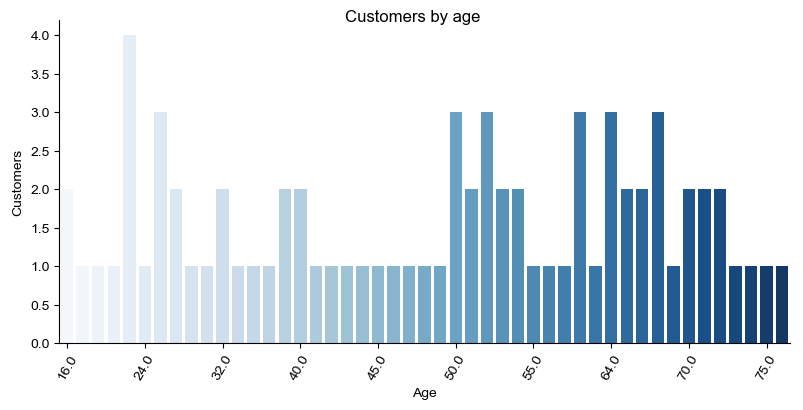

In [14]:
show_hist(df_exdup,"Age","Customers by age",5,60,"visualizations/customers by age")

## 1.5 Variable engeneering

### 1.5.1 City Customers?

Adding a variable which deferentiates a customers who lives in a city from those who are not.

In [15]:
#define cities
cities = ["Hamburg","San Francisco","Berlin","Bremen"]

In [16]:
df_exdup.loc[df_exdup["City"].isin(cities),"Dweller"] = "City"
df_exdup.loc[~df_exdup["City"].isin(cities),"Dweller"] = "Rural"

In [17]:
df_exdup.to_csv("data new/masterdata.csv",encoding = "utf-8",sep = ",",index = False)

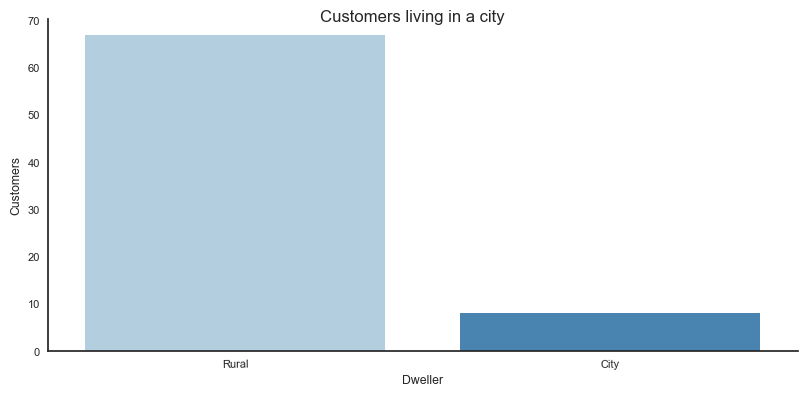

In [18]:
show_hist(df_exdup,"Dweller","Customers living in a city",1,1,"visualizations/customers living in a city")